# import modules

In [8]:
import keras
from keras.utils import plot_model,to_categorical
from keras.layers import Dense,LSTM,Bidirectional,TimeDistributed,Conv1D,MaxPool1D,Concatenate,Dropout,BatchNormalization,Add
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model


from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np

In [4]:
from scipy.signal import savgol_filter

# Load Features

In [5]:
X_features=np.load('./feature/X_feature.npy')
y=np.load('./feature/y_tone.npy')

In [6]:
X_features.shape

(4704, 50, 57)

## Encode label

In [7]:
le=LabelEncoder()
y=le.fit_transform(y)

In [8]:
CLASSES_LIST=le.classes_
print(CLASSES_LIST)

['1' '2' '3' '4']


## One-hot Encoding

In [9]:
y=to_categorical(y,num_classes=4)

In [10]:
y.shape

(4704, 4)

## split train and test

In [11]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.1,random_state=2019)

In [12]:
X_train.shape,X_test.shape

((4233, 50, 57), (471, 50, 57))

# Models


In [9]:
NUM_CLASSES=4
BATCH_SIZE=128
EPOCHS=100
MODEL_SAVE_PATH='./models/Audio_tone.h5'

In [9]:

###SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model():
    inputs = Input(shape=(50, 57))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(0.3)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = MaxPool1D(pool_size=50, strides=2)(attention_mul)
    attention_mul = Flatten()(attention_mul)
    output = Dense(4, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [10]:
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_model1():
    inputs = Input(shape=(50, 57))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(0.3)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = MaxPool1D(pool_size=50, strides=2)(attention_mul)
    output = Dense(4, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [11]:
model = attention_model1()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 57)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 50, 64)       3712        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 128)      66048       dropout[0][0]                    
_______________________________________________________________________________________

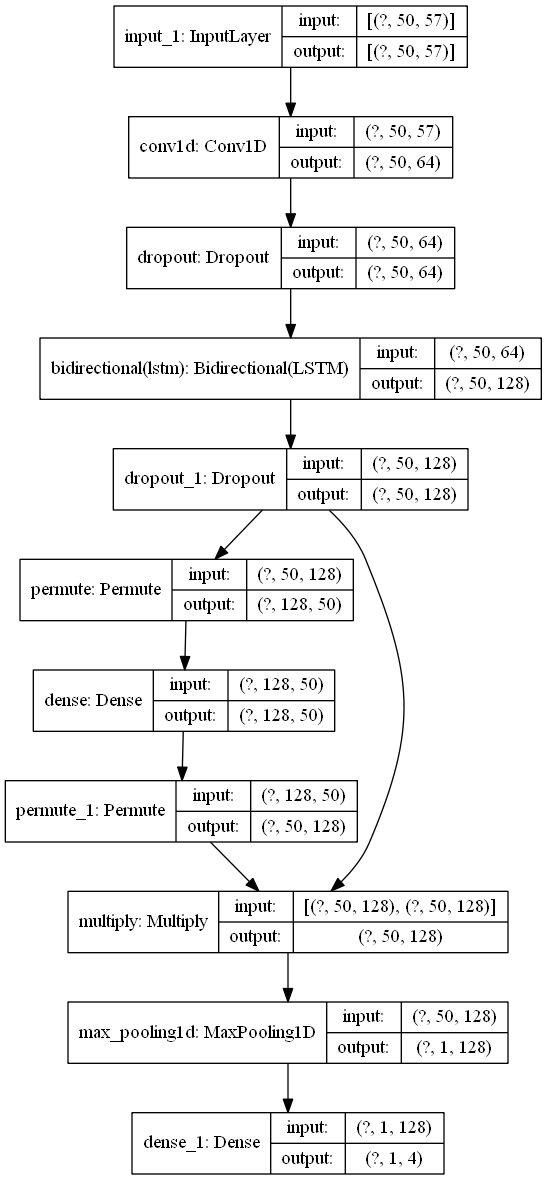

In [15]:
import pydotplus
import graphviz 
from keras.utils import plot_model
plot_model(model,to_file='.\\audio_tone.png', show_shapes=True)

NameError: name 'plot_model' is not defined

In [32]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#plot_model(model,'model_tune.jpg',show_shapes=True)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)

Epoch 1/100
33/34 [============================>.] - ETA: 0s - loss: 1.3828 - accuracy: 0.3118
Epoch 00001: val_accuracy improved from -inf to 0.38641, saving model to ./models\Audio_tone.h5
34/34 [==============================] - 3s 86ms/step - loss: 1.3828 - accuracy: 0.3121 - val_loss: 1.3754 - val_accuracy: 0.3864
Epoch 2/100
33/34 [============================>.] - ETA: 0s - loss: 1.3550 - accuracy: 0.3736
Epoch 00002: val_accuracy improved from 0.38641 to 0.43737, saving model to ./models\Audio_tone.h5
34/34 [==============================] - 2s 68ms/step - loss: 1.3549 - accuracy: 0.3733 - val_loss: 1.2993 - val_accuracy: 0.4374
Epoch 3/100
33/34 [============================>.] - ETA: 0s - loss: 1.2015 - accuracy: 0.4754
Epoch 00003: val_accuracy improved from 0.43737 to 0.57325, saving model to ./models\Audio_tone.h5
34/34 [==============================] - 2s 67ms/step - loss: 1.2014 - accuracy: 0.4753 - val_loss: 1.0376 - val_accuracy: 0.5732
Epoch 4/100
33/34 [============

### model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
plot_model(model,'model_tune.jpg',show_shapes=True)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_acc',verbose=1,save_best_only=True)
callback_list=[save_model]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)

## plot_curve

In [57]:
import sys
sys.path.append('.\\')
from helpp import plot_curve,plot_curve_with_smooth

ModuleNotFoundError: No module named 'helpp'

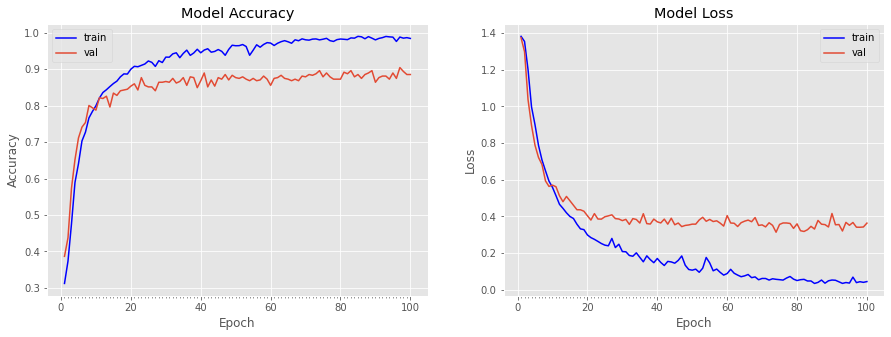

In [34]:
plot_curve(history)

In [54]:

def smooth_curve(points, factor=0.8):
    '''
    :param points: acc或者loss的点
    :param factor: 
    :return: 
    '''
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points   
def plot_curve_with_smooth(history):
    plt.style.use('ggplot')
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # Summarize history for accuracy
    axs[0].plot(range(1, len(history.history['accuracy']) + 1), smooth_curve(accuracy),'b')
    axs[0].plot(range(1, len(history.history['val_accuracy']) + 1), smooth_curve(val_accuracy))
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(history.history['accuracy']) + 1), len(history.history['accuracy']) / 10)
    axs[0].legend(['Smoothed training accuracy', 'Smoothed validation accuracy'], loc='best')

    # Summarize history for loss
    axs[1].plot(range(1, len(history.history['loss']) + 1), smooth_curve(loss),'b')
    axs[1].plot(range(1, len(history.history['val_loss']) + 1), smooth_curve(val_loss))
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(history.history['loss']) + 1), len(history.history['loss']) / 10)
    axs[1].legend(['Smoothed training loss', 'Smoothed validation loss'], loc='best')
    # Show the plot
    plt.show()


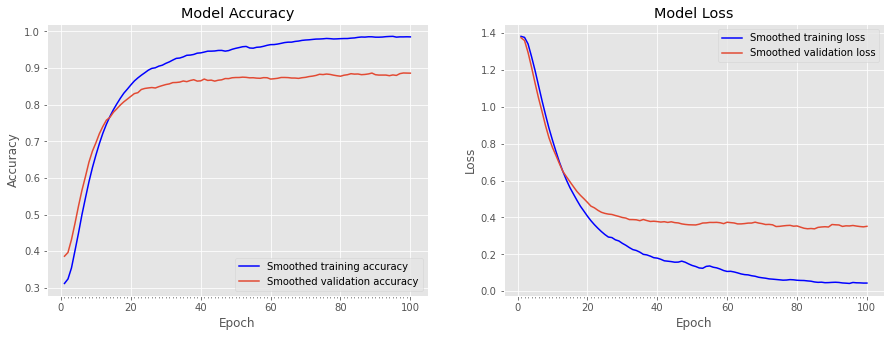

In [58]:
plot_curve_with_smooth(history)

## confusion_metrix

In [14]:
# model.load_weights('./models/lstm.h5')

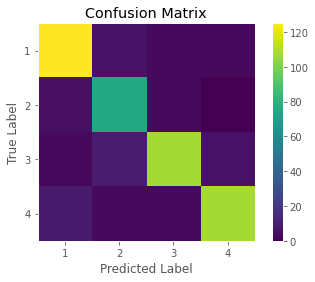

In [59]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = [1,2,3,4]
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

In [60]:
con_matrix

array([[125,   6,   3,   3],
       [  5,  76,   3,   0],
       [  3,  10, 108,   6],
       [  9,   3,   3, 108]], dtype=int64)

## classfication_report

In [61]:
from sklearn.metrics import classification_report
# model.load_weights('./models/lstm.h5')

In [62]:
target_names = ['1', '2', '3','4']
print(classification_report(y_true,y_pred,digits=4,labels=[0,1,2,3],target_names=target_names))

              precision    recall  f1-score   support

           1     0.8803    0.9124    0.8961       137
           2     0.8000    0.9048    0.8492        84
           3     0.9231    0.8504    0.8852       127
           4     0.9231    0.8780    0.9000       123

    accuracy                         0.8854       471
   macro avg     0.8816    0.8864    0.8826       471
weighted avg     0.8887    0.8854    0.8858       471



# predict

In [20]:
import librosa
import sklearn
def get_mfcc_feature(path,maxlen=50):
    x, sr = librosa.load(path)
    # extract mfcc
    mfcc = librosa.feature.mfcc(x, sr=sr)
    # Center to the mean and component wise scale to unit variance
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    mfcc_diff = np.diff(mfcc, axis=0)
    mfcc_diff_diff = np.diff(mfcc_diff, axis=0)
    # concatenate mfcc,mfcc_diff and mfcc_diff_diff
    mfccs = np.concatenate([mfcc, mfcc_diff, mfcc_diff_diff], axis=0).T
    #pad the mfccs_feature
    if mfccs.shape[0]<maxlen:
        mfccs=np.concatenate([mfccs,np.zeros((maxlen-mfccs.shape[0],57))],axis=0)
    return mfccs

In [21]:
wav_file='./voice_data/person10_time1_group1_ba_1.wav'

In [22]:
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=1)[0]
print('Predict Label:%s'%(CLASSES_LIST[pred]))

Predict Label:1
